In [1]:
import scipy.io, math, os
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from utils import *
from nltk.corpus import cmudict
from numpy import linalg as LA
import seaborn as sns
import pylab
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from scipy.spatial import distance
from scipy.cluster import hierarchy

In [2]:
def get_srate(file_number):
    directory = 'data/Data/F1/mat'
    
    # TODO: needs to ignore the .DS_Store file in a better way
    file = sorted(os.listdir(directory))[file_number + 1]
    
    f = os.path.join(directory, file)
    mat = scipy.io.loadmat(f)['usctimit_ema_f1_{:03}_{:03}'.format(file_number*5 + 1, file_number*5 + 5)]
    
    #returns the srate which is awkwardly stored here
    return mat[0][1][1][0][0]

In [3]:
# can't put this in the utils file 
d = cmudict.dict()
def nsyl(word):
    try:
        return [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]]
    except KeyError:
        #if word not found in cmudict
        return syllables(word)

In [4]:
def get_pos_list(position, dimension, file_number, starting_point, end_point):
    values = []
    if dimension == 'x':
        dim = 0
    elif dimension == 'y':
        dim = 1 
    elif dimension == 'z':
        dim = 2
    else:
        raise ValueError

    positions = ['UL', 'LL', 'JW', 'TB', 'TD', 'TT']
    dataframes = [UL_df, LL_df, JW_df, TB_df, TD_df, TT_df]
    index = positions.index(position)
    
    for i in range(end_point - starting_point):
        coordinate = (dataframes[index][file_number][dim][starting_point + i])
        if str(coordinate) != 'nan':
            values.append(coordinate)
            
    return np.array(values)

In [5]:
subjects = ['F1', 'F5', 'M1', 'M3']
directory = 'data/Data/{}/mat'.format(subjects[0])
counter = 1
UL_df, LL_df, JW_df, TD_df, TB_df, TT_df = [], [], [], [], [], []

for filename in sorted(os.listdir(directory)):
    if filename.endswith('.mat'):
        f = os.path.join(directory, filename)
        mat = scipy.io.loadmat(f)
        # takes the data that is stored at the key that precedes the data for each .mat file
        data = mat['usctimit_ema_{}_{:03}_{:03}'.format(subjects[0].lower(), counter, counter + 4)]
        counter += 5

        # make dataframes of the six positions
        UL_df.append(pd.DataFrame.from_dict(data[0][1][2]))
        LL_df.append(pd.DataFrame.from_dict(data[0][2][2]))
        JW_df.append(pd.DataFrame.from_dict(data[0][3][2]))
        TD_df.append(pd.DataFrame.from_dict(data[0][4][2]))
        TB_df.append(pd.DataFrame.from_dict(data[0][5][2]))
        TT_df.append(pd.DataFrame.from_dict(data[0][6][2]))

In [6]:
frames = {}

with open('timestamps.txt', 'r') as file:
    timestamps = file.read().splitlines()
    for word_number, line in enumerate(timestamps):
        split_line = line.split(',')
        sent_number = int(split_line[-1])
        
        # find start and end by multiplying the timestamps with the sampling rate
        starting_point = math.floor(float(split_line[2]) * get_srate(int(split_line[0])))
        end_point = math.ceil(float(split_line[3]) * get_srate(int(split_line[0])))
        
        # make dataframe for each word, so 3481 dataframes, for x and y seperately, and ingnoring z
        # TODO: make this more efficient 
        data = {'word' : [split_line[1]],
                'srate': [get_srate(int(split_line[0]))],
                'sent' : [int(split_line[-1])],
                'syl'  : [nsyl(split_line[1])],
                'ULx'  : [get_pos_list('UL', 'x', int(split_line[0]), starting_point, end_point)],
                'ULy'  : [get_pos_list('UL', 'y', int(split_line[0]), starting_point, end_point)],
                'LLx'  : [get_pos_list('LL', 'x', int(split_line[0]), starting_point, end_point)],
                'LLy'  : [get_pos_list('LL', 'y', int(split_line[0]), starting_point, end_point)],
                'JWx'  : [get_pos_list('JW', 'x', int(split_line[0]), starting_point, end_point)],
                'JWy'  : [get_pos_list('JW', 'y', int(split_line[0]), starting_point, end_point)],
                'TDx'  : [get_pos_list('TD', 'x', int(split_line[0]), starting_point, end_point)],
                'TDy'  : [get_pos_list('TD', 'y', int(split_line[0]), starting_point, end_point)],
                'TBx'  : [get_pos_list('TB', 'x', int(split_line[0]), starting_point, end_point)],
                'TBy'  : [get_pos_list('TB', 'y', int(split_line[0]), starting_point, end_point)],
                'TTx'  : [get_pos_list('TT', 'x', int(split_line[0]), starting_point, end_point)],
                'TTy'  : [get_pos_list('TT', 'y', int(split_line[0]), starting_point, end_point)]}
        
        df = pd.DataFrame(data)
        frames[word_number] = df

In [7]:
syl1_words, syl2_words, syl3_words = {}, {}, {}
syl4_words, syl5_words, syl6_words = {}, {}, {}

syl_frames = [syl1_words, syl2_words, 
              syl3_words, syl4_words, 
              syl5_words, syl6_words]

for i in range(1, len(syl_frames)+1):
    for count, frame in enumerate(frames):
        try:
            if frames[frame].at[0, 'syl'][0] == i:
                syl_frames[i-1][count] = frames[frame]
        except:
            if frames[frame].at[0, 'syl'] == i:
                syl_frames[i-1][count] = frames[frame]

In [8]:
sensors = ['ULx', 'ULy', 'LLx', 'LLy', 
           'JWx', 'JWy', 'TDx', 'TDy', 
           'TBx', 'TBy', 'TTx', 'TTy']

for frame in syl_frames:
    # target length is the the word with the most samples in that syllable category
    target_length = longest(frame)
    for word in frame:
        for sensor in sensors:
            array = frame[word].at[0, sensor]
            pad_length = int((target_length - len(array))/2)
            
            # checks if the pad length results in the correct target length
            if (target_length - pad_length*2 - len(array)) == 0:
                padded_array = np.pad(array, (pad_length, ), 'mean')
                frame[word].at[0, sensor] = padded_array

            # if not, that means the total samples to be padded on both sides was odd, so it 
            # needs a little reshaping to have the correct length
            else:
                padded_array = np.pad(array, (pad_length+1, pad_length), 'mean')
                frame[word].at[0, sensor] = padded_array

In [9]:
syl1_matrices, syl2_matrices, syl3_matrices = {}, {}, {}
syl4_matrices, syl5_matrices, syl6_matrices = {}, {}, {}

syl_matrices = [syl1_matrices, syl2_matrices, 
                syl3_matrices, syl4_matrices, 
                syl5_matrices, syl6_matrices] 

# transform all the dataframes into matrices 
for count, frame in enumerate(syl_frames):
    for word in frame:
        # TODO: make this prettier 
        syl_matrices[count][word] = [syl_frames[count][word]['ULx'][0], 
                                     syl_frames[count][word]['ULy'][0], 
                                     syl_frames[count][word]['LLx'][0], 
                                     syl_frames[count][word]['LLy'][0], 
                                     syl_frames[count][word]['JWx'][0], 
                                     syl_frames[count][word]['JWy'][0], 
                                     syl_frames[count][word]['TDx'][0], 
                                     syl_frames[count][word]['TDy'][0], 
                                     syl_frames[count][word]['TBx'][0], 
                                     syl_frames[count][word]['TBy'][0], 
                                     syl_frames[count][word]['TTx'][0], 
                                     syl_frames[count][word]['TTy'][0]]
    

In [10]:
difference_matrix_1, difference_matrix_2, difference_matrix_3 = [], [], []
difference_matrix_4, difference_matrix_5, difference_matrix_6 = [], [], []

difference_matrices = [difference_matrix_1, difference_matrix_2, 
                       difference_matrix_3, difference_matrix_4, 
                       difference_matrix_5, difference_matrix_6]

for i, matrix in enumerate(syl_matrices):
    for row_word in syl_matrices[i]:
        row = np.array([])
        for column_word in syl_matrices[i]:
            frob = frobenius_norm(syl_matrices[i][row_word], syl_matrices[i][column_word])
            row = np.append(row, frob)

        difference_matrices[i].append(row)
    

In [14]:
syl3 = []
for frame in syl3_words:
    syl3.append(frame)
    
labels = []
for i in syl3:
    labels.append(frames[i].at[0, 'word'])

In [15]:
diff3 = np.array([difference_matrix_3])
df = pd.DataFrame(diff3[0])
df.columns, df.index = labels, labels

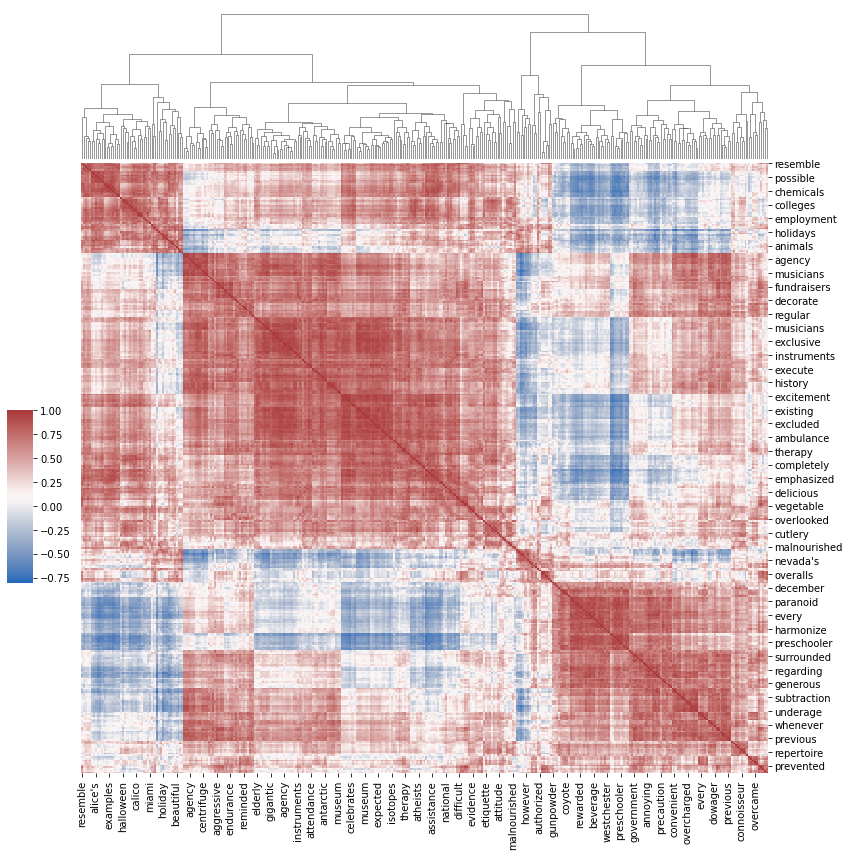

In [17]:
correlations = df.corr()
correlations_array = np.asarray(df.corr())

row_linkage = hierarchy.linkage(
    distance.pdist(correlations_array), method='average')

col_linkage = hierarchy.linkage(
    distance.pdist(correlations_array.T), method='average')

clustermap = sns.clustermap(correlations, row_linkage=row_linkage, 
                            col_linkage=col_linkage, 
                            dendrogram_ratio=(.1, .2),
                            cbar_pos=(.02, .32, .03, .2),
                            linewidths=0, figsize=(12, 12), 
                            cmap='vlag')

clustermap.ax_row_dendrogram.remove()
plt.savefig('F1.png')